In [54]:
import pandas as pd
import re
import glob
import matplotlib.pyplot as plt

In [55]:
# Define a pattern to match file details and pixel change count
pattern = r'\\([^\\]+)_resized\.tif \((\w+)\): (\d+) pixels changed'

# Initialize a dictionary to store the data
data = {}

# List all txt files (modify the path as needed)
file_list = glob.glob('./Corruption_pixels_data/*.txt')

# Loop through each file
for file_path in file_list:
    # Extract the file percentage (e.g., '2' from '2.txt')
    percentage = re.search(r'(\d+)\.txt', file_path).group(1) + '%'
    
    # Open the current file
    with open(file_path, 'r') as file:
        for line in file:
            match = re.search(pattern, line)
            if match:
                file_name = match.group(1)  # File name
                corruption_type = match.group(2)  # Corruption type
                pixels_changed = int(match.group(3))  # Pixels changed
                
                # If file_name and corruption_type combo not yet in dict, initialize a sub-dict
                if (file_name, corruption_type) not in data:
                    data[(file_name, corruption_type)] = {}
                
                # Add the pixels changed for the current percentage
                data[(file_name, corruption_type)][percentage] = pixels_changed

# Convert the dictionary into a DataFrame
df = pd.DataFrame.from_dict(data, orient='index')

# Reset index and split the multi-index into separate columns
df = df.reset_index()
df.columns = ['file_name', 'corruption_type'] + df.columns[2:].tolist()

# Sort the percentage columns numerically
percentage_columns = sorted(df.columns[2:], key=lambda x: int(x.rstrip('%')))
df = df[['file_name', 'corruption_type'] + percentage_columns]

print(df)

# df.to_csv("./Corruption_pixels_data/Corruptions.csv", index=False)


          file_name corruption_type    2%    12%    15%    17%    20%    25%  \
0       NDWI_Mask_0         Erosion     0      0  26545  40724  50302  63286   
1    NDWI_Mask_1000         Erosion   920    920    920    920    920    920   
2    NDWI_Mask_1001         Erosion     0  24231  24231  24231  24231  24231   
3    NDWI_Mask_1002         Erosion  4606  10986  10986  10986  10986  10986   
4    NDWI_Mask_1003         Erosion     0  28260  38474  42517  51404  63645   
..              ...             ...   ...    ...    ...    ...    ...    ...   
667   NDWI_Mask_618        Dilation     0  27623  36949  42484  52120  65337   
668   NDWI_Mask_619        Dilation     0  25031  38124  38124  38124  56166   
669   NDWI_Mask_620        Dilation     0  28516  38419  38419  48406  63279   
670   NDWI_Mask_621        Dilation     0  23598  38154  34611  51367  63429   
671   NDWI_Mask_622        Dilation  2986  28594  39505  43240  51965  63754   

       30%  
0    63286  
1      920  


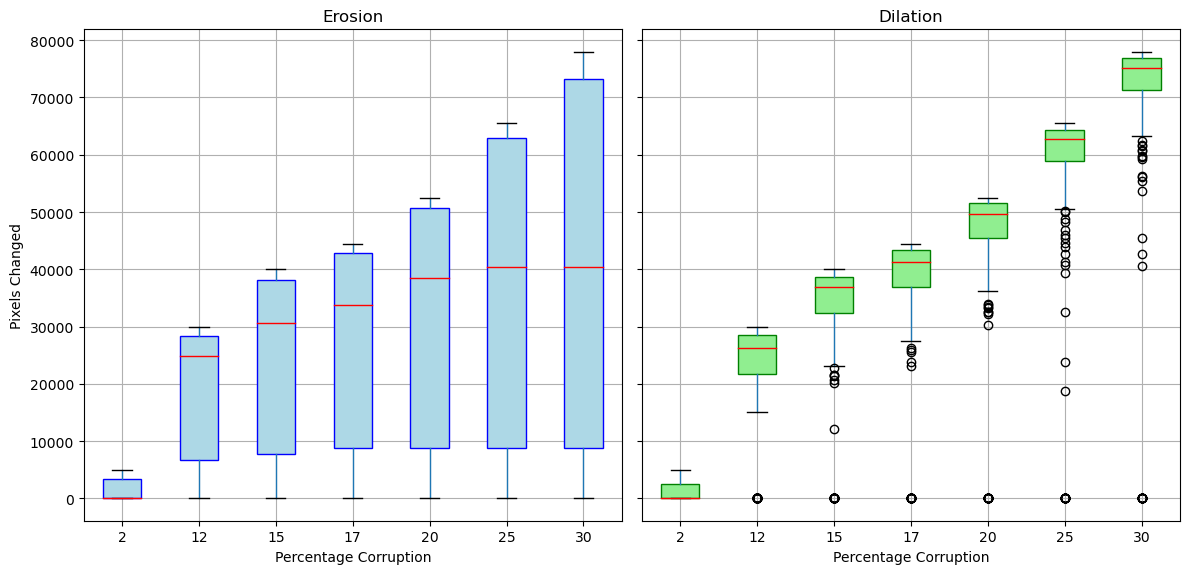

In [56]:
# Assuming the DataFrame 'df' has already been created with sorted percentage columns
# Filter the DataFrame for 'Erosion' and 'Dilation' corruption types
# df = pd.read_csv("./Corruption_pixels_data/Corruptions.csv")
# print(df.columns)

melted_erosion_df = df[df['corruption_type'] == 'Erosion'].melt(id_vars=['file_name', 'corruption_type'], 
                                                               value_vars=df.columns[2:], 
                                                               var_name='percentage', 
                                                               value_name='pixels_changed')

melted_dilation_df = df[df['corruption_type'] == 'Dilation'].melt(id_vars=['file_name', 'corruption_type'], 
                                                                  value_vars=df.columns[2:], 
                                                                  var_name='percentage', 
                                                                  value_name='pixels_changed')

melted_erosion_df['percentage'] = melted_erosion_df['percentage'].str.rstrip('%').astype(int)
melted_erosion_df = melted_erosion_df.sort_values(by='percentage')

melted_dilation_df['percentage'] = melted_dilation_df['percentage'].str.rstrip('%').astype(int)
melted_dilation_df = melted_dilation_df.sort_values(by='percentage')


# Create subplots for the boxplots
fig, axs = plt.subplots(1, 2, figsize=(12, 6), sharey=True)

# Colors for filled boxplots
fill_color_erosion = 'lightblue'
fill_color_dilation = 'lightgreen'

# Boxplot for Erosion
boxprops = dict(facecolor=fill_color_erosion, color='blue')  # Filled with color and borders
medianprops = dict(color='red', linewidth=1)  # Red median line
melted_erosion_df.boxplot(column='pixels_changed', by='percentage', ax=axs[0], 
                          boxprops=boxprops, medianprops=medianprops, patch_artist=True)
axs[0].set_title('Erosion')
axs[0].set_xlabel('Percentage Corruption')
axs[0].set_ylabel('Pixels Changed')

# Boxplot for Dilation with red median lines
boxprops = dict(facecolor=fill_color_dilation, color='green')  # Filled with color and borders
melted_dilation_df.boxplot(column='pixels_changed', by='percentage', ax=axs[1], 
                           boxprops=boxprops, medianprops=medianprops, patch_artist=True)
axs[1].set_title('Dilation')
axs[1].set_xlabel('Percentage Corruption')

# Adjust layout and save the figure
plt.suptitle('')  # Suppress the automatic 'Boxplot grouped by' title
plt.tight_layout()
plt.savefig('./Corruption_pixels_data/corruption_boxplots_filled_with_red_medians.png')

# Display the plot (optional)
plt.show()